# Transfer Learning
## Imports and Version Selection


In [0]:
# TensorFlow ≥2.0 is required for this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# check if GPU is available as this notebook will be very slow without GPU
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

# jupyters magic command
%matplotlib inline

     |████████████████████████████████| 399kB 4.1MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.18-py2.py3-none-any.whl size=8393 sha256=ff7f4a24d9cf5721e9ce2c9d5e594a3643f64a82898d3eec562278fad25a8465
  Stored in directory: /root/.cache/pip/wheels/c9/24/f5/8258a898fd2cd12315ca220f208be60cc08dc29bc6bd73a0df
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=0ae6bbc142f8b6525904924101fcddf5d091cf2adcf6d28cb14b1daf3ecc769b
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


In [0]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    # run Xceptions preprocessing function
    preprocessed_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return preprocessed_image, label

## Loading and Preprocessing

In [0]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

batch_size = 32

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
  test_data = test_data.map(preprocess).batch(batch_size).prefetch(1)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
  test_data = test_data.map(preprocess).batch(batch_size).prefetch(1) 

dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


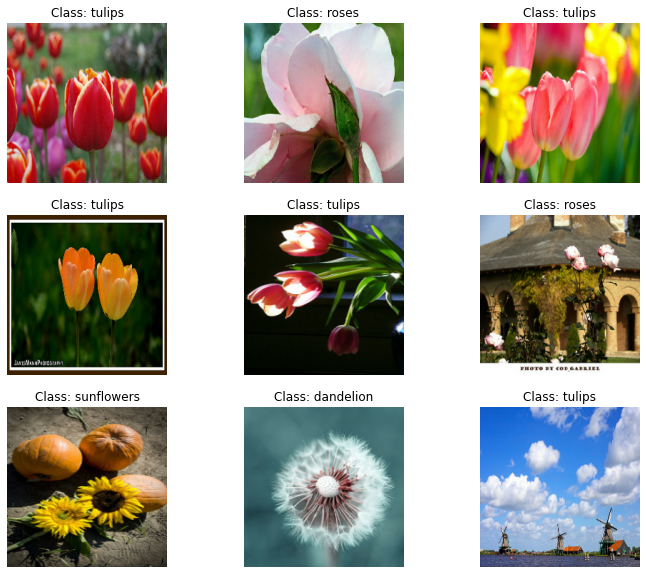

In [0]:
# show some images from the dataset
helpers.plot_images(train_data.unbatch().take(9).map(lambda x, y: ((x + 1) / 2, y)), class_names)

## Definition and Training

In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model = Xception(
    weights='imagenet',
    include_top=False
)
model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model.layers:
  layer.trainable = False

![picture](https://drive.google.com/uc?id=1HZoeZaJTuxfBgRIa-iXSmblVqav_5tQ-)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data
)

Epoch 1/5
92/92 [==============================] - 36s 388ms/step - loss: 0.9322 - accuracy: 0.6570 - val_loss: 137.3918 - val_accuracy: 0.1676
Epoch 2/5
92/92 [==============================] - 35s 379ms/step - loss: 0.6798 - accuracy: 0.7681 - val_loss: 6.4545 - val_accuracy: 0.4441
Epoch 3/5
92/92 [==============================] - 35s 378ms/step - loss: 0.4244 - accuracy: 0.8556 - val_loss: 0.5848 - val_accuracy: 0.8065
Epoch 4/5
92/92 [==============================] - 35s 378ms/step - loss: 0.2895 - accuracy: 0.9087 - val_loss: 0.5933 - val_accuracy: 0.8256
Epoch 5/5
92/92 [==============================] - 35s 378ms/step - loss: 0.1671 - accuracy: 0.9418 - val_loss: 0.3851 - val_accuracy: 0.8815


![picture](https://drive.google.com/uc?id=1PvelbcVzJ9aEuq79C5njvx71MDBnmKyo)

In [0]:
# to finetune the model, we have to set more layers to trainable
# and reduce the learning rate drastically to prevent
# destroying of weights
for layer in base_model.layers:
  layer.trainable = True

In [0]:
# reduce the learning rate to not damage the pretrained weights
# model will need longer to train because all the layers are trainable
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune=model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
92/92 [==============================] - 36s 387ms/step - loss: 0.1017 - accuracy: 0.9721 - val_loss: 0.2701 - val_accuracy: 0.9074
Epoch 2/10
92/92 [==============================] - 35s 378ms/step - loss: 0.0685 - accuracy: 0.9775 - val_loss: 0.2804 - val_accuracy: 0.9087
Epoch 3/10
92/92 [==============================] - 35s 378ms/step - loss: 0.0692 - accuracy: 0.9802 - val_loss: 0.2713 - val_accuracy: 0.9237
Epoch 4/10
92/92 [==============================] - 35s 379ms/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.2789 - val_accuracy: 0.9155
Epoch 5/10
92/92 [==============================] - 35s 378ms/step - loss: 0.0388 - accuracy: 0.9901 - val_loss: 0.2774 - val_accuracy: 0.9183
Epoch 6/10
92/92 [==============================] - 35s 379ms/step - loss: 0.0281 - accuracy: 0.9928 - val_loss: 0.2995 - val_accuracy: 0.9128
Epoch 7/10
92/92 [==============================] - 35s 379ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.3086 - val_accuracy: 0.9196

## Visualization and Evaluation

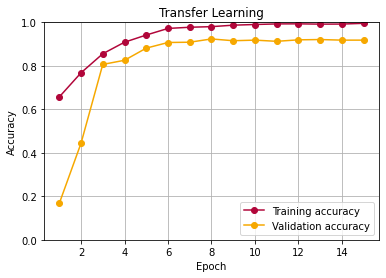

In [0]:
# add the two histories and print the diagram
helpers.plot_two_histories(history, history_finetune)

# Transfer Learning with Data Augmentation
## Model Definition

In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model_data_augmentation = Xception(
    weights='imagenet',
    include_top=False
)
model = GlobalAveragePooling2D()(base_model_data_augmentation.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
data_augmentation_model = Model(base_model_data_augmentation.input, output_layer)

## Adjust Data Augmentation

In [0]:
# resize the images to a uniform size
def preprocess_with_data_augmentation(image, label):
  resized_image = tf.image.resize(image, [224, 224])

  # data augmentation with Tensorflow
  augmented_image = tf.image.random_flip_left_right(resized_image)
  augmented_image = tf.image.random_hue(augmented_image, 0.08)
  augmented_image = tf.image.random_saturation(augmented_image, 0.6, 1.6)
  augmented_image = tf.image.random_brightness(augmented_image, 0.05)
  augmented_image = tf.image.random_contrast(augmented_image, 0.7, 1.3)

  # run Xceptions preprocessing function
  preprocessed_image = tf.keras.applications.xception.preprocess_input(augmented_image)
  return preprocessed_image, label

In [0]:
batch_size = 32
try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True) 
augmented_train_data = train_data.map(preprocess_with_data_augmentation).batch(batch_size).prefetch(1)

## Training

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model_data_augmentation.layers:
  layer.trainable = False
data_augmentation_model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_data_augmentation = data_augmentation_model.fit(
    augmented_train_data,
    epochs=3,
    validation_data=test_data
)

Epoch 1/3
92/92 [==============================] - 13s 137ms/step - loss: 2.4155 - accuracy: 0.7520 - val_loss: 0.7927 - val_accuracy: 0.8828
Epoch 2/3
92/92 [==============================] - 12s 128ms/step - loss: 1.6251 - accuracy: 0.8270 - val_loss: 0.9737 - val_accuracy: 0.8760
Epoch 3/3
92/92 [==============================] - 12s 129ms/step - loss: 1.3145 - accuracy: 0.8450 - val_loss: 0.5669 - val_accuracy: 0.8992


## Finetuning

In [0]:
# to finetune the model, we have to set more layers to trainable
# and reduce the learning rate drastically to prevent
# destroying of weights
for layer in base_model_data_augmentation.layers:
  layer.trainable = True
  # reduce the learning rate to not damage the pretrained weights
# model will need longer to train because all the layers are trainable
data_augmentation_model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune_data_augmentation = data_augmentation_model.fit(
    augmented_train_data,
    epochs=30,
    validation_data=test_data
)

Epoch 1/30
92/92 [==============================] - 36s 387ms/step - loss: 0.6197 - accuracy: 0.8205 - val_loss: 0.4202 - val_accuracy: 0.8924
Epoch 2/30
92/92 [==============================] - 35s 379ms/step - loss: 0.1853 - accuracy: 0.9387 - val_loss: 0.2191 - val_accuracy: 0.9264
Epoch 3/30
92/92 [==============================] - 35s 378ms/step - loss: 0.0745 - accuracy: 0.9762 - val_loss: 0.2350 - val_accuracy: 0.9414
Epoch 4/30
92/92 [==============================] - 35s 379ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 0.2229 - val_accuracy: 0.9469
Epoch 5/30
92/92 [==============================] - 35s 379ms/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.3124 - val_accuracy: 0.9387
Epoch 6/30
92/92 [==============================] - 35s 378ms/step - loss: 0.0151 - accuracy: 0.9942 - val_loss: 0.3101 - val_accuracy: 0.9428
Epoch 7/30
92/92 [==============================] - 35s 379ms/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.2850 - val_accuracy: 0.9496

## Visualization

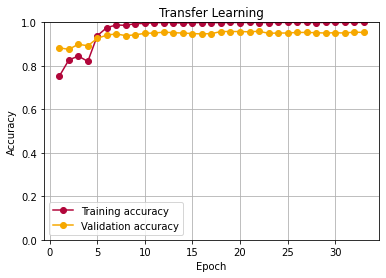

In [0]:
# add the two histories and print the diagram
helpers.plot_two_histories(history_data_augmentation, history_finetune_data_augmentation)